   seed     HV_GA  HV_NSGA2
0     0  0.037446  0.042624
1     1  0.048618  0.041496
2     2  0.042288  0.042189
3     3  0.038828  0.040413
4     4  0.043728  0.035663
5     5  0.049733  0.035577
6     6  0.037350  0.039881
7     7  0.043581  0.042857
8     8  0.039025  0.039309
9     9  0.042676  0.043057
         HV_GA  HV_NSGA2
mean  0.042327  0.040307
std   0.004344  0.002779


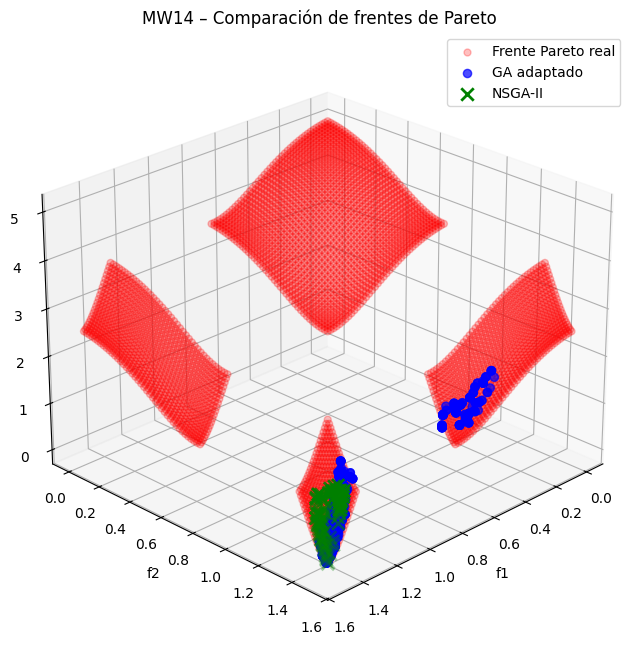

In [7]:


import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume


# ============================================================
# PROBLEMA MW14 (3 objetivos, 30 variables, CON restricciones)
# ============================================================

problem = get_problem("mw14", n_var=30, n_obj=3)

N_VAR = problem.n_var
N_OBJ = problem.n_obj

XL = 0.0
XU = 1.5

POP_SIZE = 100
BUDGET = 10_000
N_GEN = BUDGET // POP_SIZE


# ============================================================
# EVALUACIÓN (fitness + violación de restricciones)
# ============================================================

def eval_pop(X):
    F, G = problem.evaluate(X, return_values_of=["F", "G"])

    if G is None:
        CV = np.zeros(len(F))
    else:
        G = np.asarray(G)
        if G.ndim == 1:
            G = G[:, None]
        CV = np.sum(np.maximum(G, 0.0), axis=1)

    return F, CV


# ============================================================
# OPERADORES GA
# ============================================================

def sbx_crossover(p1, p2, pcross=0.9, eta=15):
    if random.random() > pcross:
        return p1.copy(), p2.copy()

    c1, c2 = p1.copy(), p2.copy()

    for i in range(len(p1)):
        if random.random() <= 0.5 and abs(p1[i] - p2[i]) > 1e-14:
            x1, x2 = min(p1[i], p2[i]), max(p1[i], p2[i])
            rand = random.random()

            beta = 1.0 + 2.0 * (x1 - XL) / (x2 - x1)
            alpha = 2.0 - beta ** -(eta + 1)
            betaq = (rand * alpha) ** (1/(eta+1)) if rand <= 1/alpha else (1/(2-rand*alpha)) ** (1/(eta+1))
            child1 = 0.5*((x1+x2) - betaq*(x2-x1))

            beta = 1.0 + 2.0 * (XU - x2) / (x2 - x1)
            alpha = 2.0 - beta ** -(eta + 1)
            betaq = (rand * alpha) ** (1/(eta+1)) if rand <= 1/alpha else (1/(2-rand*alpha)) ** (1/(eta+1))
            child2 = 0.5*((x1+x2) + betaq*(x2-x1))

            c1[i], c2[i] = child1, child2

    return np.clip(c1, XL, XU), np.clip(c2, XL, XU)


def gaussian_mutation(x, pmut=None, sigma=0.05):
    if pmut is None:
        pmut = 1.0 / N_VAR

    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0, sigma)

    return np.clip(y, XL, XU)

def polynomial_mutation(child, pmut=0.1, eta_m=20):
    mutant = child.copy()
    n_var = len(mutant)

    for i in range(n_var):
        if np.random.rand() < pmut:
            x = mutant[i]

            delta1 = x
            delta2 = 1.0 - x
            rand = np.random.rand()
            mut_pow = 1.0 / (eta_m + 1.0)

            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta_m + 1.0))
                deltaq = val ** mut_pow - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta_m + 1.0))
                deltaq = 1.0 - val ** mut_pow

            mutant[i] = np.clip(x + deltaq, 0.0, 1.0)

    return np.clip(mutant, XL, XU)


# ============================================================
# CROWDING DISTANCE
# ============================================================

def crowding_distance(F):
    n = len(F)
    if n <= 2:
        return np.full(n, np.inf)

    m = F.shape[1]
    cd = np.zeros(n)

    for j in range(m):
        order = np.argsort(F[:, j])
        cd[order[0]] = cd[order[-1]] = np.inf

        fmin = F[order[0], j]
        fmax = F[order[-1], j]
        if fmax == fmin:
            continue

        for i in range(1, n - 1):
            cd[order[i]] += (F[order[i+1], j] - F[order[i-1], j]) / (fmax - fmin)

    return cd


# ============================================================
# SELECCIÓN AMBIENTAL (restricciones + ND + crowding)
# ============================================================

def environmental_selection(pop, F, CV, pop_size):
    new_idx = []
    feas = (CV == 0)

    if np.any(feas):
        Ff = F[feas]
        idx_f = np.where(feas)[0]
        fronts = NonDominatedSorting().do(Ff)

        for front in fronts:
            real_idx = idx_f[front]
            if len(new_idx) + len(real_idx) <= pop_size:
                new_idx.extend(real_idx.tolist())
            else:
                cd = crowding_distance(F[real_idx])
                order = np.argsort(-cd)
                remain = pop_size - len(new_idx)
                new_idx.extend(real_idx[order[:remain]].tolist())
                break

    if len(new_idx) < pop_size:
        infeas = np.where(~feas)[0]
        order = infeas[np.argsort(CV[infeas])]
        new_idx.extend(order[:pop_size - len(new_idx)].tolist())

    idx = np.array(new_idx)
    return pop[idx], F[idx], CV[idx]


# ============================================================
# GA MULTIOBJETIVO (MW14)
# ============================================================

def evolve_my_ga(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    pop = np.random.uniform(XL, XU, size=(POP_SIZE, N_VAR))
    F, CV = eval_pop(pop)

    archive_F = []
    archive_CV = []

    for _ in range(N_GEN):
        children = []

        while len(children) < POP_SIZE:
            i, j = random.sample(range(len(pop)), 2)
            c1, c2 = sbx_crossover(pop[i], pop[j])
            children.append(polynomial_mutation(c1))
            children.append(polynomial_mutation(c2))

        children = np.array(children[:POP_SIZE])
        Fc, CVc = eval_pop(children)

        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        CV = np.hstack([CV, CVc])

        pop, F, CV = environmental_selection(pop, F, CV, POP_SIZE)

        archive_F.append(F)
        archive_CV.append(CV)

    archive_F = np.vstack(archive_F)
    archive_CV = np.hstack(archive_CV)

    feas = archive_CV == 0
    Ff = archive_F[feas] if np.any(feas) else archive_F
    nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)

    return Ff[nd]


# ============================================================
# NSGA-II (baseline)
# ============================================================

def run_nsga2(seed=0):
    algo = NSGA2(
        pop_size=POP_SIZE,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0 / N_VAR, eta=20),
        eliminate_duplicates=True
    )

    res = minimize(problem, algo, ('n_gen', N_GEN), seed=seed, verbose=False)
    F = res.pop.get("F")
    CV = res.pop.get("CV").sum(axis=1)

    feas = CV == 0
    Ff = F[feas] if np.any(feas) else F
    nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)

    return Ff[nd]


# ============================================================
# EXPERIMENTOS + HIPERVOLUMEN
# ============================================================

ref_point = np.array([1.6, 1.6, 1.6])
hv = Hypervolume(ref_point)

rows = []

for seed in range(10):
    F_ga = evolve_my_ga(seed)
    F_ns = run_nsga2(seed)

    rows.append({
        "seed": seed,
        "HV_GA": hv.do(F_ga),
        "HV_NSGA2": hv.do(F_ns)
    })

df = pd.DataFrame(rows)
print(df)
print(df[["HV_GA", "HV_NSGA2"]].agg(["mean", "std"]))


# ============================================================
# GRÁFICA 3D (mejor seed)
# ============================================================

best_seed = int(df.loc[df["HV_GA"].idxmax(), "seed"])

F_ga = evolve_my_ga(best_seed)
F_ns = run_nsga2(best_seed)
real_pf = problem.pareto_front()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(real_pf[:,0], real_pf[:,1], real_pf[:,2],
           color="red", alpha=0.25, s=25,
           label="Frente Pareto real")

ax.scatter(F_ga[:,0], F_ga[:,1], F_ga[:,2],
           color="blue", alpha=0.7, s=35,
           label="GA adaptado")

ax.scatter(F_ns[:,0], F_ns[:,1], F_ns[:,2],
           color="green", marker="x", s=80,
           linewidths=2, label="NSGA-II")

ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_zlabel("f3")
ax.set_title("MW14 – Comparación de frentes de Pareto")

ax.view_init(elev=25, azim=45)
ax.legend()
plt.show()



In [8]:
# ============================================================
# GA MULTIOBJETIVO v2 (MEJORADO) – MW14
# ============================================================

def evolve_my_ga_v2(seed=0, archive_size=300):
    random.seed(seed)
    np.random.seed(seed)

    # -------- Inicialización --------
    pop = np.random.uniform(XL, XU, size=(POP_SIZE, N_VAR))
    F, CV = eval_pop(pop)

    # Archivo elitista
    A_F = None
    A_CV = None

    for gen in range(N_GEN):

        # -------- Mutación adaptativa --------
        sigma = 0.2 * (1 - gen / N_GEN) + 0.02

        children = []

        while len(children) < POP_SIZE:
            i, j = random.sample(range(len(pop)), 2)
            c1, c2 = sbx_crossover(pop[i], pop[j])
            c1 = gaussian_mutation(c1, sigma=sigma)
            c2 = gaussian_mutation(c2, sigma=sigma)
            children.append(c1)
            children.append(c2)

        children = np.array(children[:POP_SIZE])
        Fc, CVc = eval_pop(children)

        # -------- Unión población + hijos --------
        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        CV = np.hstack([CV, CVc])

        # -------- Selección ambiental --------
        pop, F, CV = environmental_selection(pop, F, CV, POP_SIZE)

        # -------- Actualizar archivo elitista --------
        if A_F is None:
            A_F = F.copy()
            A_CV = CV.copy()
        else:
            A_F = np.vstack([A_F, F])
            A_CV = np.hstack([A_CV, CV])

        # Mantener solo ND factibles en archivo
        feas = (A_CV == 0)
        if np.any(feas):
            Ff = A_F[feas]
        else:
            order = np.argsort(A_CV)
            Ff = A_F[order[:archive_size]]

        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        A_F = Ff[nd]
        A_CV = np.zeros(len(A_F))

        # Recorte por crowding si el archivo crece demasiado
        if len(A_F) > archive_size:
            cd = crowding_distance(A_F)
            order = np.argsort(-cd)
            A_F = A_F[order[:archive_size]]
            A_CV = np.zeros(len(A_F))

    # -------- Resultado final --------
    nd = NonDominatedSorting().do(A_F, only_non_dominated_front=True)
    return A_F[nd]


In [9]:
# ============================================================
# NUEVO EXPERIMENTO COMPARATIVO
# ============================================================

rows = []

for seed in range(10):
    F_ga  = evolve_my_ga(seed)
    F_ga2 = evolve_my_ga_v2(seed)
    F_ns  = run_nsga2(seed)

    rows.append({
        "seed": seed,
        "HV_GA": hv.do(F_ga),
        "HV_GA2": hv.do(F_ga2),
        "HV_NSGA2": hv.do(F_ns)
    })

df2 = pd.DataFrame(rows)
print(df2)
print(df2[["HV_GA", "HV_GA2", "HV_NSGA2"]].agg(["mean", "std"]))


   seed     HV_GA    HV_GA2  HV_NSGA2
0     0  0.037446  0.045473  0.042624
1     1  0.048618  0.048730  0.041496
2     2  0.042288  0.050099  0.042189
3     3  0.038828  0.041898  0.040413
4     4  0.043728  0.046640  0.035663
5     5  0.049733  0.038937  0.035577
6     6  0.037350  0.043796  0.039881
7     7  0.043581  0.039748  0.042857
8     8  0.039025  0.041530  0.039309
9     9  0.042676  0.048270  0.043057
         HV_GA    HV_GA2  HV_NSGA2
mean  0.042327  0.044512  0.040307
std   0.004344  0.003924  0.002779


Explora una sola región
❌ Poca diversidad global

In [11]:
def adaptive_gaussian_mutation(x, gen, max_gen, pmut=None, sigma_max=0.15, sigma_min=0.02):
    if pmut is None:
        pmut = 1.0 / N_VAR

    # sigma decrece con las generaciones
    sigma = sigma_max - (sigma_max - sigma_min) * (gen / max_gen)

    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0, sigma)

    return np.clip(y, XL, XU)


In [12]:
from sklearn.cluster import KMeans

def niching_selection(F, k=4, max_per_cluster=60):
    """
    Selecciona soluciones repartidas entre k regiones del frente
    """
    if len(F) <= k:
        return np.arange(len(F))

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    labels = kmeans.fit_predict(F)

    selected = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        if len(idx) == 0:
            continue

        if len(idx) > max_per_cluster:
            cd = crowding_distance(F[idx])
            order = np.argsort(-cd)
            idx = idx[order[:max_per_cluster]]

        selected.extend(idx.tolist())

    return np.array(selected)


In [13]:
def evolve_my_ga_v3(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    pop = np.random.uniform(XL, XU, size=(POP_SIZE, N_VAR))
    F, CV = eval_pop(pop)

    archive_F = []

    for gen in range(N_GEN):

        # --- Reproducción ---
        children = []
        while len(children) < POP_SIZE:
            i, j = random.sample(range(len(pop)), 2)
            c1, c2 = sbx_crossover(pop[i], pop[j], pcross=0.9, eta=20)
            children.append(gaussian_mutation(c1, sigma=0.1))
            children.append(gaussian_mutation(c2, sigma=0.1))

        children = np.array(children[:POP_SIZE])
        Fc, CVc = eval_pop(children)

        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        CV = np.hstack([CV, CVc])

        pop, F, CV = environmental_selection(pop, F, CV, POP_SIZE)

        # --- Archivo factible ---
        feas = CV == 0
        if np.any(feas):
            archive_F.append(F[feas])

    archive_F = np.vstack(archive_F)

    # --- Frente no dominado ---
    nd = NonDominatedSorting().do(archive_F, only_non_dominated_front=True)
    F_nd = archive_F[nd]

    # 🔥 NICHING CLAVE
    idx = niching_selection(F_nd, k=4, max_per_cluster=80)
    return F_nd[idx]


In [14]:

rows = []

for seed in range(10):
    F_ga  = evolve_my_ga(seed)
    F_ga2 = evolve_my_ga_v2(seed)
    F_ga3 = evolve_my_ga_v3(seed)
    F_ns  = run_nsga2(seed)

    rows.append({
        "seed": seed,
        "HV_GA": hv.do(F_ga),
        "HV_GA2": hv.do(F_ga2),
        "HV_GA3": hv.do(F_ga3),
        "HV_NSGA2": hv.do(F_ns)
    })

df3 = pd.DataFrame(rows)
print(df3)
print(df3[["HV_GA", "HV_GA2", "HV_GA3", "HV_NSGA2"]].agg(["mean", "std"]))


   seed     HV_GA    HV_GA2    HV_GA3  HV_NSGA2
0     0  0.037446  0.045473  0.035621  0.042624
1     1  0.048618  0.048730  0.045311  0.041496
2     2  0.042288  0.050099  0.043831  0.042189
3     3  0.038828  0.041898  0.040208  0.040413
4     4  0.043728  0.046640  0.040933  0.035663
5     5  0.049733  0.038937  0.036627  0.035577
6     6  0.037350  0.043796  0.047007  0.039881
7     7  0.043581  0.039748  0.044715  0.042857
8     8  0.039025  0.041530  0.040589  0.039309
9     9  0.042676  0.048270  0.045156  0.043057
         HV_GA    HV_GA2    HV_GA3  HV_NSGA2
mean  0.042327  0.044512  0.042000  0.040307
std   0.004344  0.003924  0.003839  0.002779


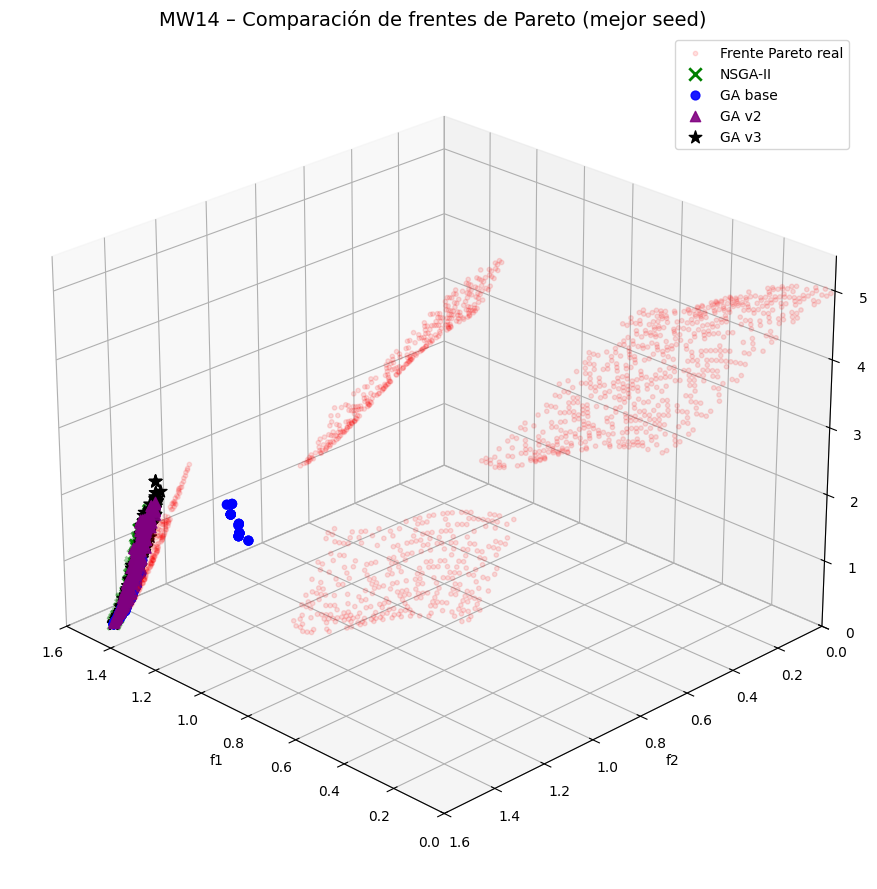

In [15]:
# ============================================================
# GRÁFICA 3D FINAL – TODOS LOS FRENTES BIEN VISIBLES
# ============================================================

best_seed = int(df3.loc[df3["HV_GA3"].idxmax(), "seed"])

F_ga1 = evolve_my_ga(best_seed)        # GA base
F_ga2 = evolve_my_ga_v2(best_seed)     # GA v2
F_ga3 = evolve_my_ga_v3(best_seed)     # GA v3  <-- NUEVO
F_ns  = run_nsga2(best_seed)

# -------- Frente Pareto real (submuestreado) --------
real_pf = problem.pareto_front()

np.random.seed(0)
idx = np.random.choice(len(real_pf), size=1500, replace=False)
real_pf = real_pf[idx]

# -------- Figura --------
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection="3d")

# Frente Pareto real
ax.scatter(
    real_pf[:,0], real_pf[:,1], real_pf[:,2],
    color="red",
    alpha=0.12,
    s=10,
    label="Frente Pareto real"
)

# NSGA-II
ax.scatter(
    F_ns[:,0], F_ns[:,1], F_ns[:,2],
    color="green",
    marker="x",
    s=80,
    linewidths=2,
    label="NSGA-II"
)

# GA base
ax.scatter(
    F_ga1[:,0], F_ga1[:,1], F_ga1[:,2],
    color="blue",
    s=40,
    alpha=0.9,
    label="GA base"
)

# GA v2
ax.scatter(
    F_ga2[:,0], F_ga2[:,1], F_ga2[:,2],
    color="purple",
    marker="^",
    s=55,
    alpha=0.9,
    label="GA v2"
)

# 🔥 GA v3 (MEJORADO)
ax.scatter(
    F_ga3[:,0], F_ga3[:,1], F_ga3[:,2],
    color="black",
    marker="*",
    s=90,
    alpha=1.0,
    label="GA v3"
)

# -------- Ejes y vista --------
ax.set_xlabel("f1")
ax.set_ylabel("f2")
ax.set_zlabel("f3")

# Rangos correctos MW14
ax.set_xlim(0, 1.6)
ax.set_ylim(0, 1.6)
ax.set_zlim(0, 5.5)

# Vista óptima para ver TODOS los frentes
ax.view_init(elev=25, azim=135)

ax.set_title("MW14 – Comparación de frentes de Pareto (mejor seed)", fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()
